In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from htmresearch.support.gridcells.context_integration.context_layer import ContextLayer
from htmresearch.support.gridcells.context_integration.utils import (create_module_shape, 
                                                                     create_action_tensor, 
                                                                     get_actions, 
                                                                     get_closed_3d_path,
                                                                     load_digit_features)

from scipy.stats import entropy

%matplotlib inline
%load_ext autoreload
%autoreload 2



m = 5   # Number of modules
n = 30   # Approximate number of cells per module dimension
d = 20   # Cells per minicolumn
w = 3    # Code weight of the sensory SDR

zero = np.zeros(2*m)
dx,dy,dz = get_actions(m,3)

module_shapes = create_module_shape(m,n, rmin=-10,rmax=5)
action_tensor = create_action_tensor(m) 

X, V = get_closed_3d_path(num_samples=20, radius=5)

CL  = ContextLayer(layer_height=d, module_shapes=module_shapes, action_map=action_tensor, max_activity=200) 

F = load_digit_features(w=w, shape=CL.layer.shape)

print CL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

**Context Layer:**
------------------
Number of cells:	 3520
Layer Shape:		 (20, 176)
Hyper-Module Shapes:
[[33 22]
 [30 21]
 [24 28]
 [32 26]
 [20 33]]
Module bounds: [   0  726 1356 2028 2860 3520]
Number of grid cells:	 3520
Activity bound:		 200
------------------


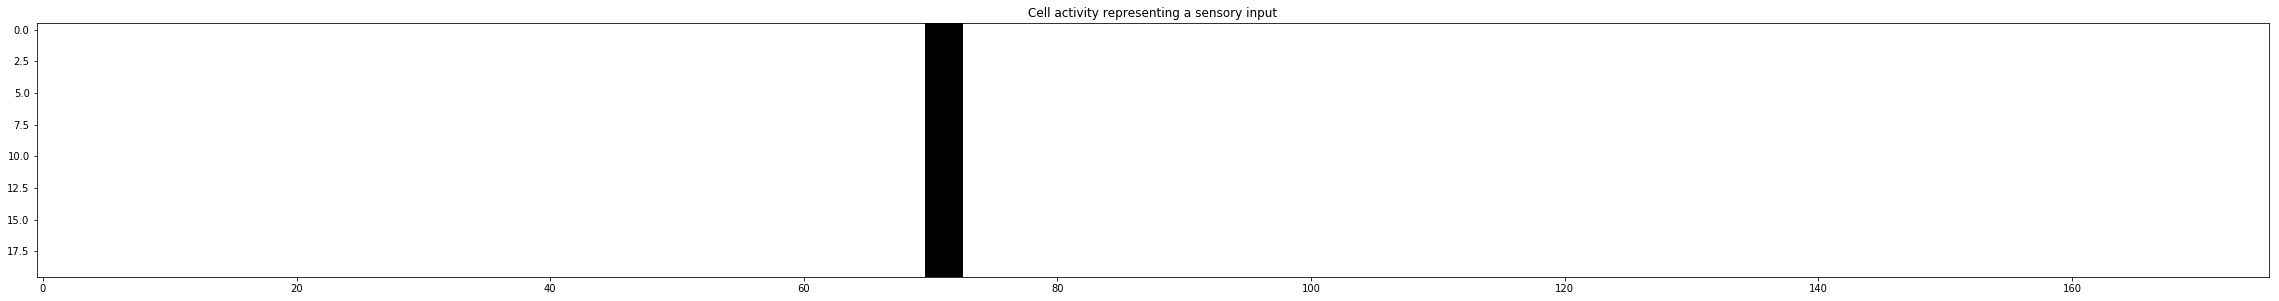

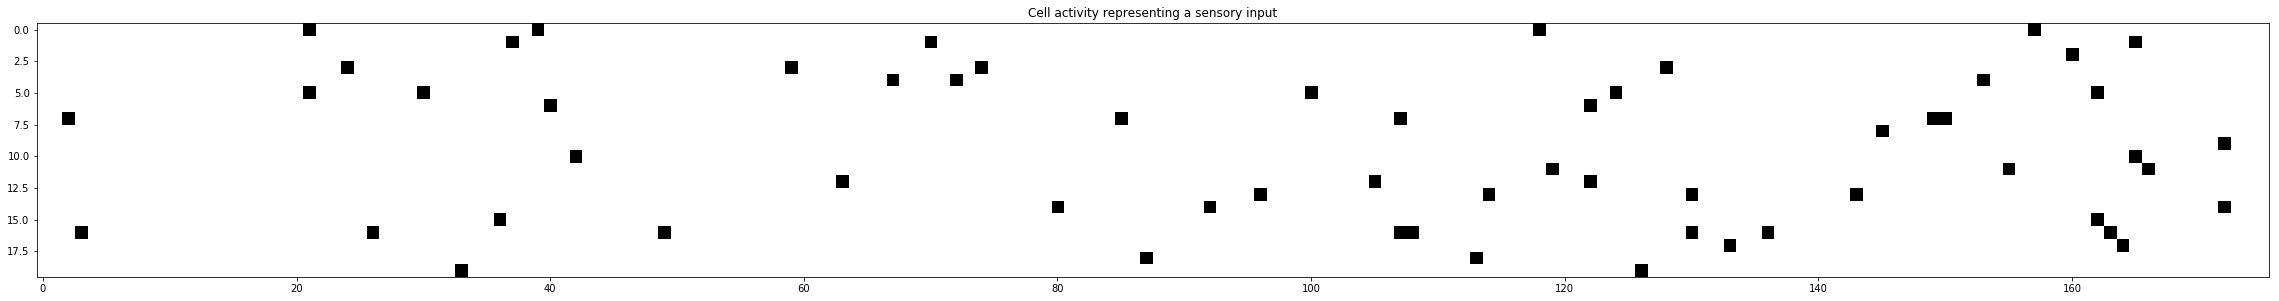

In [8]:

plt.figure(figsize=(40,20))
plt.title("Cell activity representing a sensory input")
plt.imshow(F[4], cmap="binary", vmin=0, vmax=1)

CL.extend(zero, F[4])

plt.figure(figsize=(40,20))
plt.title("Cell activity representing a sensory input")
plt.imshow(CL.explore(1*dx, mentally=True), cmap="binary", vmin=0, vmax=1)


# plt.figure(figsize=(40,20))
# plt.title("Cells that belong to module $M_0$")
# plt.imshow(CL.highlight_module(0), cmap="binary", vmin=0, vmax=1)


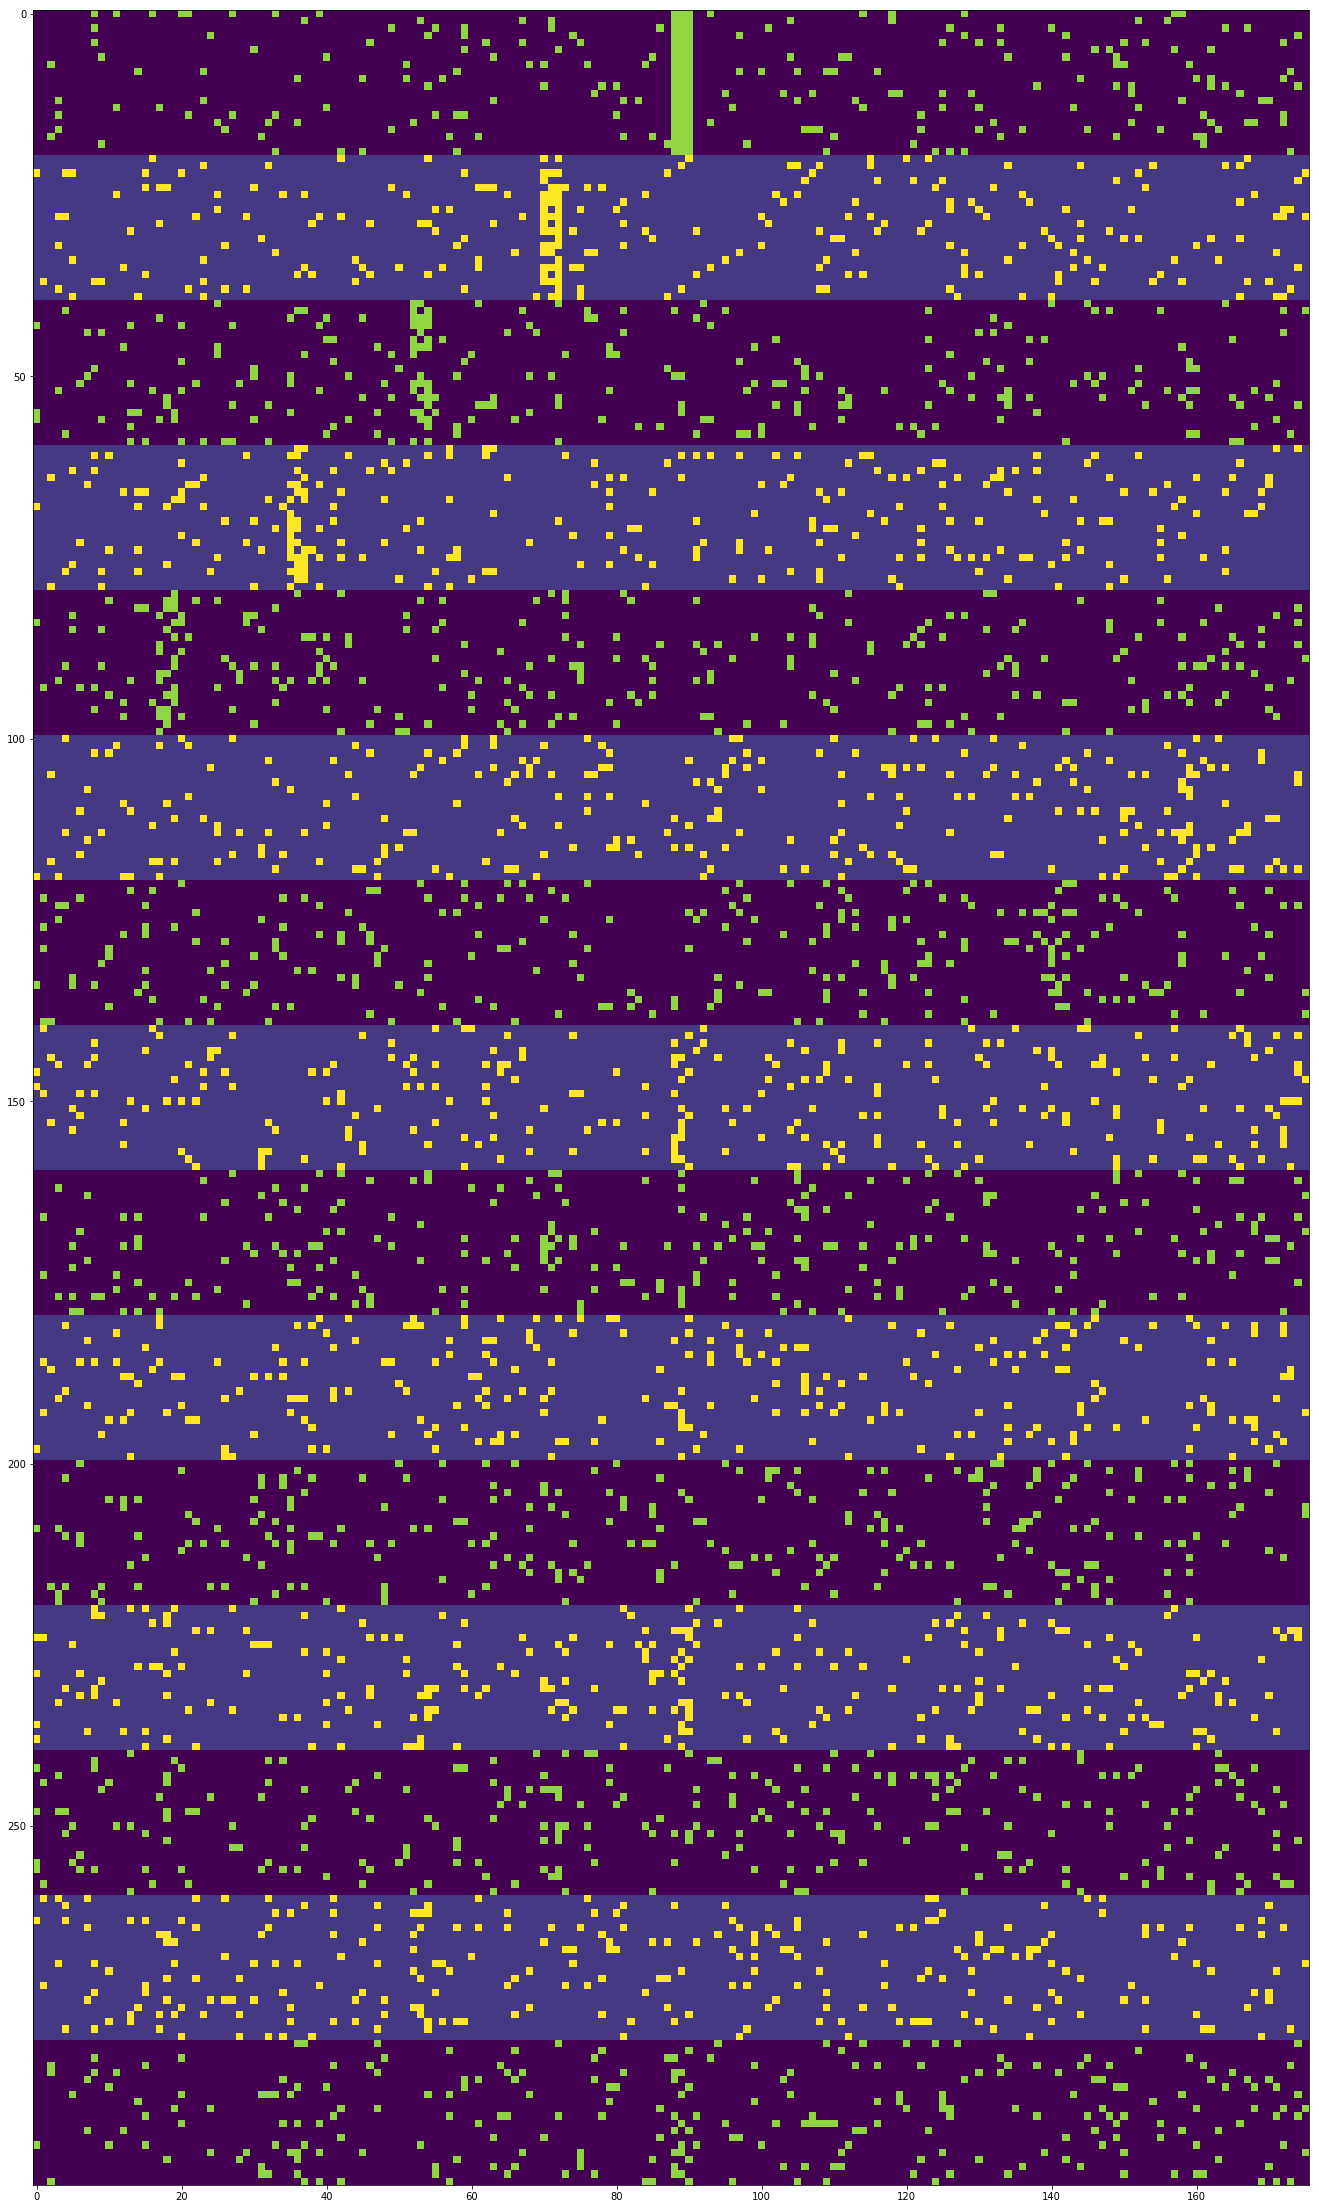

In [9]:
CL.clear()
CL.extend(zero, F[0])
T = 500
for t in range(T):
    CL.extend(dx , F[1 + t%9])

    
plt.figure(figsize=(40,40))
img = np.concatenate([CL.explore(-t*dx, mentally=True) + (t%2)*0.2 for t in range(0,15)], axis=0)
plt.imshow(img, cmap="viridis")
plt.show()
    

In [9]:
"""
Creating an environment and 
a path of an agent
"""
from htmresearch.support.gridcells.random_walk import smooth_torus_walk

env = np.zeros((40,40))
env = (np.random.sample(env.shape) < 0.1).astype(float)

num_steps = 100000
X, _ = smooth_torus_walk(num_steps, start=[0.5,0.5], min_speed=0.02, max_speed=0.055, sigma=12.5)

X[:,0] *= (env.shape[0] )
X[:,1] *= (env.shape[1] )
X = X.astype(int)

V = np.zeros(X.shape)
for t in range( X.shape[0] - 1):
    V[t,:] = X[t+1] - X[t] 


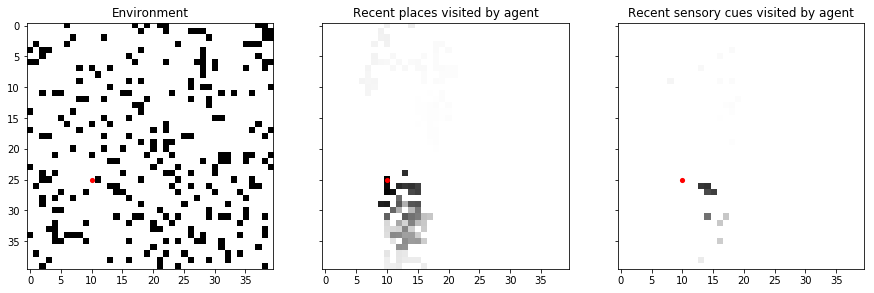

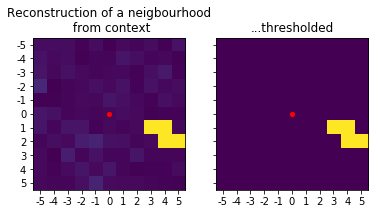

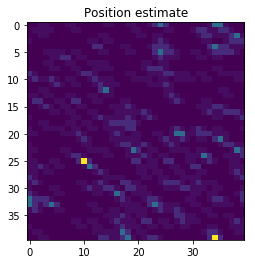

In [21]:
from htmresearch.support.gridcells.context_integration.utils import create_env_nbh_tensor, position_estimate, diffusion


env = (np.random.sample(env.shape) < 0.15).astype(float)
CL  = ContextLayer(layer_height=d, module_shapes=module_shapes, action_map = action_tensor, max_activity=(d*w)*20) 

r = 5
T = 300
nbh_tensor    = create_env_nbh_tensor(env, r)
heatmap_agent = np.zeros(env.shape)
positions  = []
heat_agent = []
nbh_rec    = []
probs      = []

for t in range(0,T):
    a = V[t,0]*dx + V[t,1]*dy
    CL.explore(a)
    
    pos = X[t+1] 
    positions.append(pos.copy())
    
    heatmap_agent *= 0.98
    heatmap_agent[pos[0],pos[1]] = 1
    
    heat_agent.append(heatmap_agent.copy())
    
    f_id = int(env[pos[0],pos[1]])
    if f_id > 0:
        CL.extend(zero, F[f_id])
    
    nbh = CL.decode_bw(r, softmax=True)
    nbh_rec.append(nbh.copy())
    
    prob = position_estimate(nbh_tensor, nbh, r )
    probs.append(prob.copy())
#     movie_frames.append(diffusion(prob))
        
# Two subplots, unpack the axes array immediately

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15, 5))

ax1.set_title('Environment')
ax1.imshow(env, cmap="binary", vmin=0, vmax=1)
ax1.scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
ax2.set_title('Recent places visited by agent')
ax2.imshow(heatmap_agent, cmap="binary", vmin=0, vmax=1)
ax2.scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
ax3.set_title("Recent sensory cues visited by agent")
ax3.imshow(heatmap_agent*env, cmap="binary", vmin=0, vmax=1)
ax3.scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)
plt.show()



nbh = CL.decode_bw(r, softmax=True)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(6, 5))
ax1.set_title("Reconstruction of a neigbourhood\n from context")
ax1.imshow(nbh)
ax1.scatter(r,r, s=10, marker="o", c="red", edgecolor='red',  lw = 2)
ax1.set_xticks(range(2*r +1))
ax1.set_xticklabels(range(-r, r+1))
ax1.set_yticks(range(2*r +1))
ax1.set_yticklabels(range(-r, r+1))

nbh = CL.decode_bw(r, threshold=0.7, softmax=True)
ax2.set_title("...thresholded")
ax2.imshow(nbh)
ax2.scatter(r,r, s=10, marker="o", c="red", edgecolor='red',  lw = 2)
ax2.set_xticks(range(2*r +1))
ax2.set_xticklabels(range(-r, r+1))
ax2.set_yticks(range(2*r +1))
ax2.set_yticklabels(range(-r, r+1))

plt.show()


# nbh = CL.decode_bw(r, threshold=0.7, softmax=True)



# plt.title("Reconstruction.. thresholded")
# plt.imshow(nbh)
# plt.scatter(r,r, s=10, marker="o", c="red", edgecolor='red',  lw = 2)
# plt.xticks(range(2*r +1), range(-r, r+1))
# plt.yticks(range(2*r +1), range(-r, r+1))
# plt.show()


prob = position_estimate(nbh_tensor, nbh, r )


plt.title("Position estimate")
plt.imshow(prob)
plt.scatter(X[t+1,1],X[t+1,0], s=10, marker="x", c="red", edgecolor='red',  lw = 0)
plt.show()




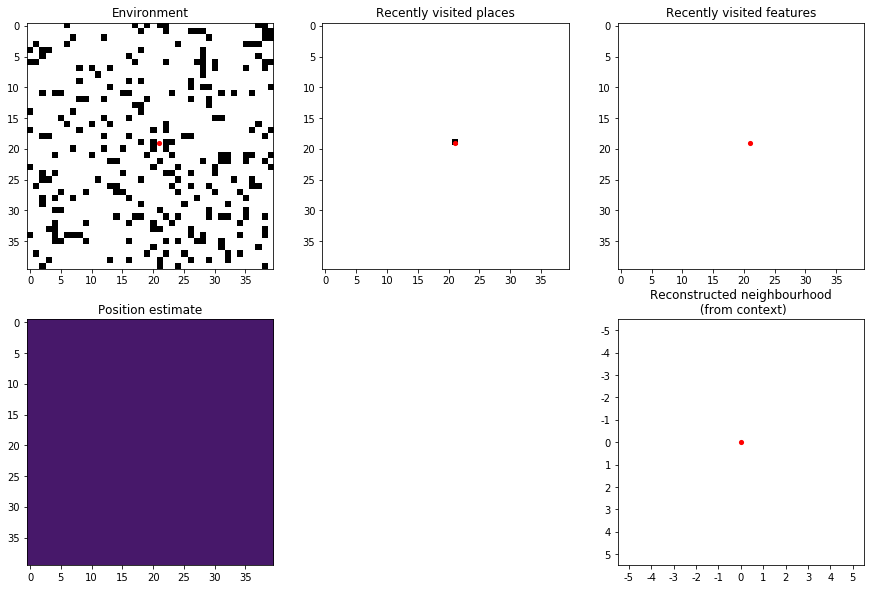

In [22]:
# First set up the figure, the axis, and the plot element we want to animate



fig, ax = plt.subplots(2, 3, figsize=(15, 10));


p = positions[0]
ax[0,0].set_title("Environment")
im1 = ax[0,0].imshow(env, cmap="binary", vmin=0, vmax=1, animated=True)
sc1 = ax[0,0].scatter(p[1],p[0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)

ax[0,1].set_title("Recently visited places")
im2 = ax[0,1].imshow(heat_agent[10], cmap="binary", vmin=0, vmax=1)
sc2 = ax[0,1].scatter(p[0],p[1], s=10, marker="o", c="red", edgecolor='red',  lw = 2)

ax[0,2].set_title("Recently visited features")
im3 = ax[0,2].imshow(heatmap_agent*env, cmap="binary", vmin=0, vmax=1)
sc3 = ax[0,2].scatter(X[t+1,1],X[t+1,0], s=10, marker="o", c="red", edgecolor='red',  lw = 2)


ax[1,0].set_title("Position estimate")
# im4 = ax[1,0].imshow(probs[-1], cmap="viridis", animated=True)
im4 = ax[1,0].imshow(env, cmap="viridis", vmin=0, vmax=0.01, animated=True)
# sc4 = ax[1,0].scatter(p[0],p[1], s=10, marker="o", c="red", edgecolor='red',  lw = 2)

ax[1,1].axis('off')

ax[1,2].set_title("Reconstructed neighbourhood\n (from context)")
im5 = ax[1,2].imshow(nbh_rec[-1], cmap="binary")
sc5 = ax[1,2].scatter(r,r, s=10, marker="o", c="red", edgecolor='red',  lw = 2)


ax[1,2].set_xticks(range(2*r +1));
ax[1,2].set_xticklabels(range(-r,  r +1));
ax[1,2].set_yticks(range(2*r +1));
ax[1,2].set_yticklabels(range(-r, r+1));
    


    
# animation function. This is called sequentially
def animate(i):
#     positions  
#     heat_agent 
#     nbh_rec    
    p = positions[i]

    im1.set_array(env)
    sc1.set_offsets(p[::-1])
    im2.set_array(heat_agent[i])
    sc2.set_offsets(p[::-1])
    im3.set_array(heat_agent[i]*env)
    sc3.set_offsets(p[::-1])
    
    prob = probs[i]
    im4.set_array(prob)
        
    nbh = nbh_rec[i]
    im5.set_array(nbh)
#     sc5.set_offsets([r,r])
    return []


# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=T, interval=100, blit=True)



In [20]:
HTML(anim.to_html5_video())